In [ ]:
!nvidia-smi

Fri Jul 17 19:51:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip uninstall keras-applications --yes

Uninstalling Keras-Applications-1.0.8:
  Successfully uninstalled Keras-Applications-1.0.8


In [ ]:
!pip install git+https://github.com/keras-team/keras-applications.git@master

  Cloning https://github.com/keras-team/keras-applications.git (to revision master) to /tmp/pip-req-build-fpz4p7i6
  Running command git clone -q https://github.com/keras-team/keras-applications.git /tmp/pip-req-build-fpz4p7i6
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-cp36-none-any.whl size=62000 sha256=09c36cbc4581b8b40516b2456dd376c3ec3a52f8c1c86ddaddd88318e2072d7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3q5qj59r/wheels/f8/3c/48/007f19c86cc5d5f276a748f003a63bc19558539eab93afb545
Successfully built Keras-Applications


In [ ]:
from keras.applications import keras_applications
from keras_applications import mobilenet_v3

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
BATCH_SIZE = 64
IMG_HEIGHT = 320
IMG_WIDTH = 320
OUT_HEIGHT = 20
OUT_WIDTH = 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/garbage_dataset.zip /content/

In [ ]:
!unzip garbage_dataset.zip

In [ ]:
list_ds = tf.data.Dataset.list_files("garbage_dataset/*")

In [ ]:
LEN_DS = len(list(list_ds))

In [ ]:
for f in list_ds.take(1):
    print(f)

tf.Tensor(b'garbage_dataset/4c6794ac-6799-11e5-8dc4-40f2e96c8ad8.jpg', shape=(), dtype=string)


In [ ]:
import pickle
with open('labels.pickle', 'rb') as f:
    lbls = pickle.load(f)

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    label = lbls[parts[-1].numpy().decode()]
    label = tf.convert_to_tensor(label, tf.float32)
    label.set_shape([OUT_HEIGHT, OUT_WIDTH, num_classes])
    return label

In [ ]:
get_label_wrapper = lambda x: tf.py_function(get_label, [x], tf.float32)

In [ ]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    return img/127.5 - 1

In [ ]:
def process_path(file_path):
    label = get_label_wrapper(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (320, 320, 3)
Label:  (20, 20, 1)


In [ ]:
# TODO - Data Augmentation
def prepare_for_training(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat() #repeat forever
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)
test_ds = ??

In [ ]:
base_model = mobilenet_v3.MobileNetV3Small(input_shape=(None, None, 3),
                              alpha=0.75,
                              minimalistic=False,
                              include_top=False,
                              weights='imagenet',
                              backend=tf.keras.backend,
                              layers=tf.keras.layers,
                              models=tf.keras.models,
                              utils=tf.keras.utils
                              )

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


4268032/4267512 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
out = base_model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 10, 10, 576)

In [ ]:
num_classes = 1

In [ ]:
sf = tf.keras.layers.Conv2D(128, kernel_size=1, strides=1)(base_model.output)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(sf)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2D(num_classes, kernel_size=1, strides=1)(sf)
sf = tf.keras.layers.Activation('sigmoid')(sf)     ## Try tanh
sf.shape

TensorShape([None, None, None, 1])

In [ ]:
model = tf.keras.models.Model(base_model.input, outputs=sf)

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
model = tfmot.quantization.keras.quantize_model(model)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv_pad (ZeroPadding2D)        (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         Conv_pad[0][0]                   
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
out = model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 20, 20, 1)

In [ ]:
import datetime

In [ ]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=2, mode="auto",
    restore_best_weights=True
)

In [ ]:
history = model.fit(train_ds, epochs=10, steps_per_epoch=50, callbacks=[tensorboard_callback, es])

Epoch 1/10
50/50 [==============================] - 4s 79ms/step - loss: 0.3645 - accuracy: 0.8500
Epoch 2/10
50/50 [==============================] - 3s 65ms/step - loss: 0.2262 - accuracy: 0.9072
Epoch 3/10
50/50 [==============================] - 3s 68ms/step - loss: 0.1434 - accuracy: 0.9440
Epoch 4/10
50/50 [==============================] - 3s 65ms/step - loss: 0.0888 - accuracy: 0.9668
Epoch 5/10
50/50 [==============================] - 3s 64ms/step - loss: 0.0546 - accuracy: 0.9814
Epoch 6/10
50/50 [==============================] - 3s 65ms/step - loss: 0.0365 - accuracy: 0.9885
Epoch 7/10
50/50 [==============================] - 3s 65ms/step - loss: 0.0275 - accuracy: 0.9915
Epoch 8/10
50/50 [==============================] - 3s 64ms/step - loss: 0.0175 - accuracy: 0.9953
Epoch 9/10
50/50 [==============================] - 3s 62ms/step - loss: 0.0138 - accuracy: 0.9961
Epoch 10/10
50/50 [==============================] - 3s 66ms/step - loss: 0.0104 - accuracy: 0.9972


In [ ]:
model.save("/content/drive/My Drive/new_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/new_model/assets


In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

In [ ]:
def mask_garbage(fpath, show=True, save=False, out_path='', resize=True):
    img = cv2.imread(fpath)
    if resize:
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    mask = np.zeros(img.shape[:2], dtype=np.float32)
    y_grid = img.shape[0]//pred.shape[0]
    x_grid = img.shape[1]//pred.shape[1]
    idy = 0
    for y in range(0, img.shape[0], y_grid):
        idx = 0
        for x in range(0, img.shape[1], x_grid):
            try:
                mask[y:y+y_grid, x:x+x_grid] = pred[idy, idx]
            except IndexError:
                pass
            idx+=1
        idy+=1
    fig = plt.figure(figsize=(8, 8), frameon=False)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.2)#, cmap='PuRd')
    if save:
        fnm = fp.split('.')[0]
        plt.savefig(out_path + fnm + '.png', bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close(fig)

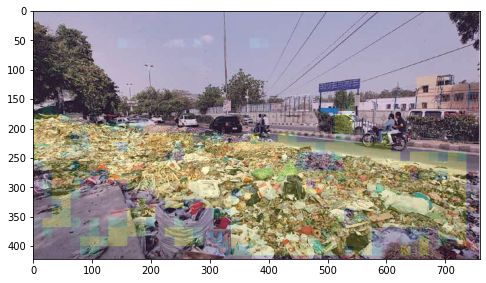

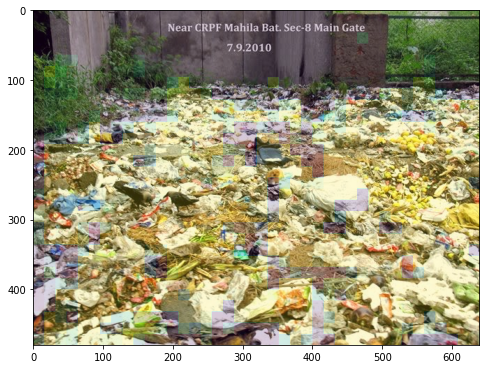

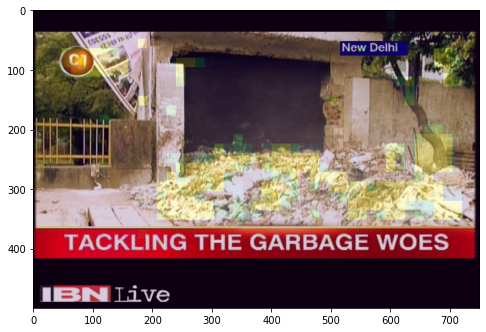

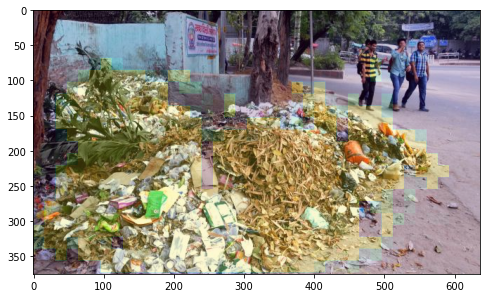

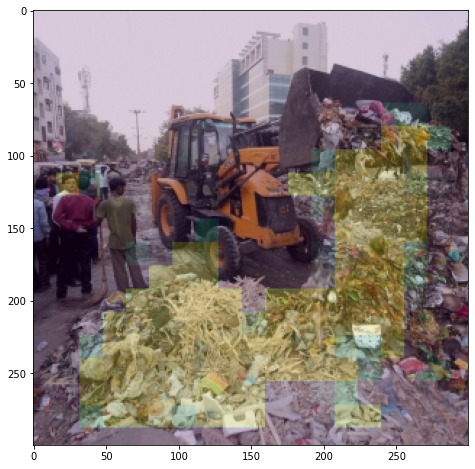

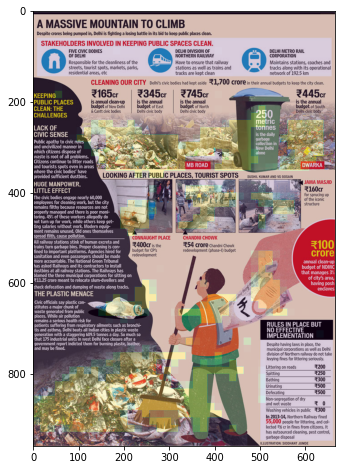

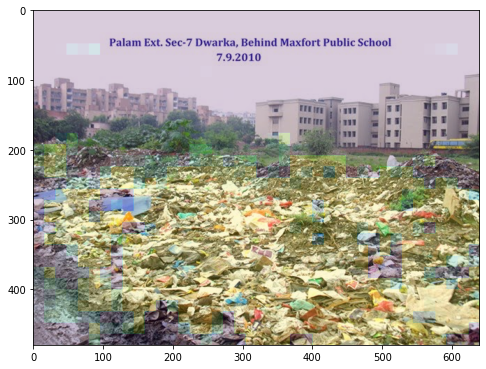

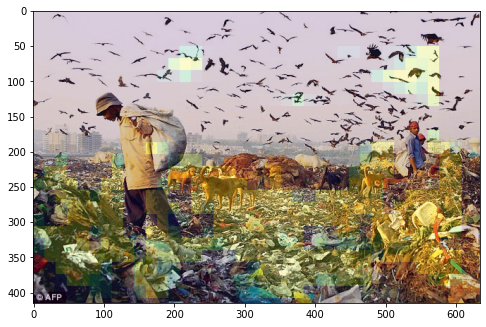

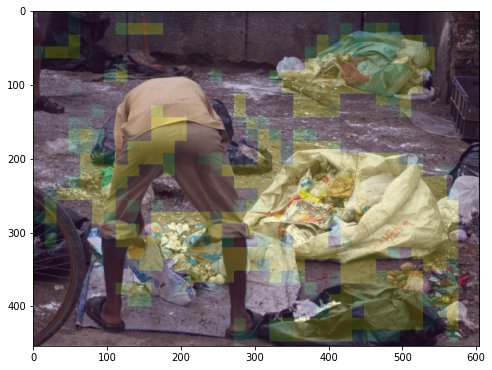

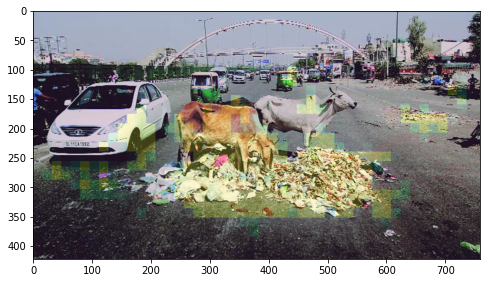

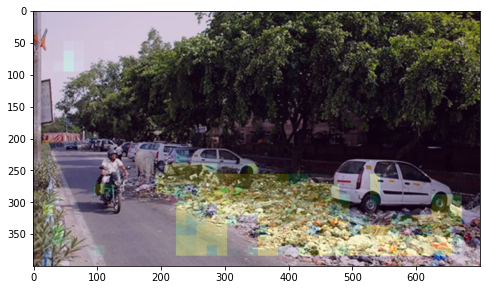

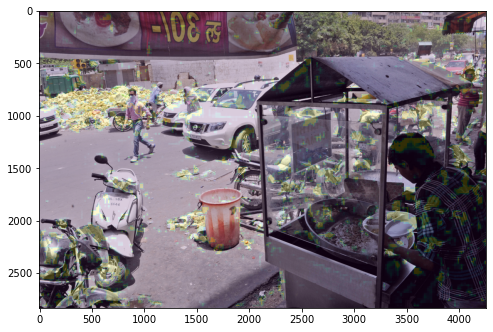

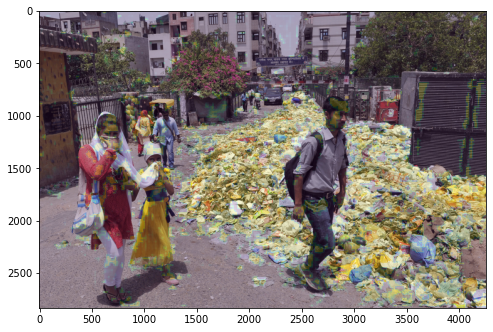

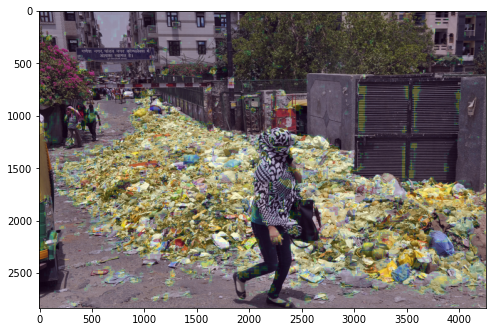

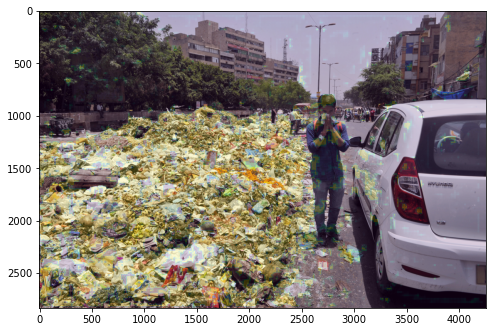

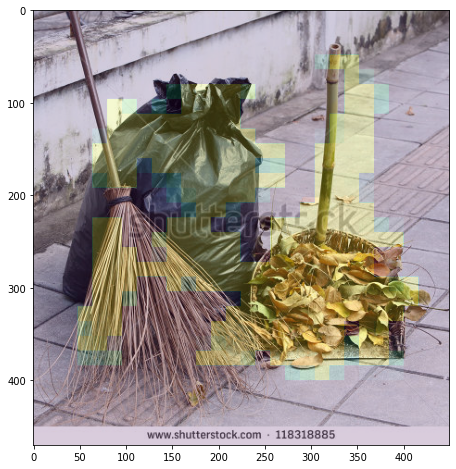

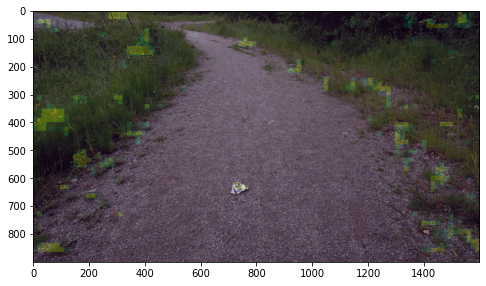

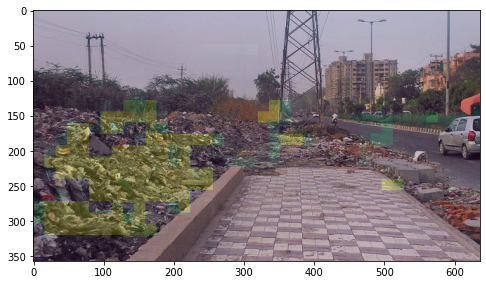

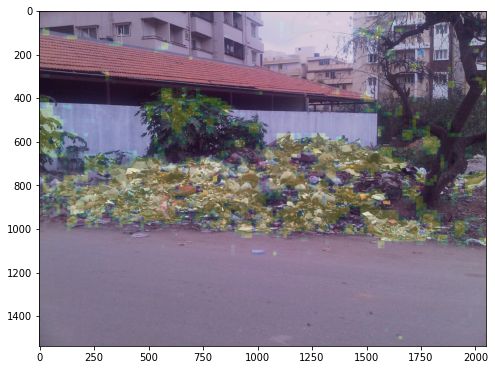

In [ ]:
out_path = "/content/drive/My Drive/new_output/"
for fp in list(lbls.keys())[35:55]:
    mask_garbage('garbage_dataset/'+fp, show=True, save=False, resize=False)

In [ ]:
import os

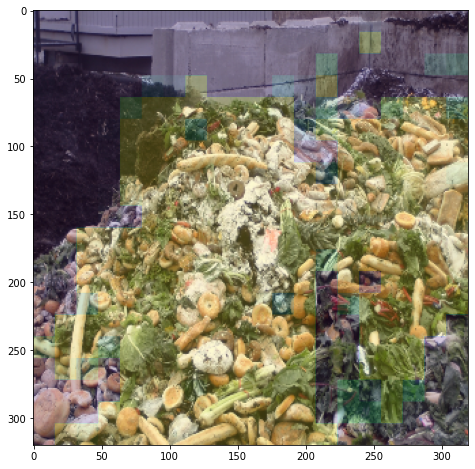

In [ ]:
tp = '/content/test/'
for i in os.listdir(tp):
    mask_garbage(tp+i, show=True)

In [ ]:
!rm test/*